# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [4]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf
from utils import decorate, savefig

## The train problem

The train problem more hypothese than the dice problem.

In [6]:
hypos = np.arange(1, 1001)
prior = Pmf(1, hypos)

But the update function is the same.

In [12]:
def update_train(pmf, data):
    """Update a pmf based on new data.
    
    pmf: Pmf of possible dice and their probabilities
    data: integer train #
    """
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()

But there are many more hypotheses

In [8]:
data = 60
posterior = prior.copy()
update_train(posterior, data)

Here's what the posterior looks like

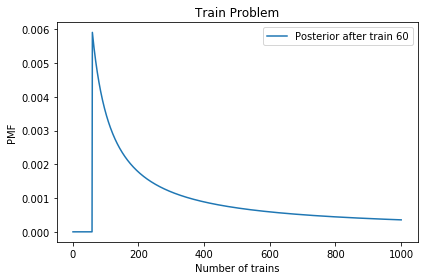

In [13]:
posterior.plot(label='Posterior after train 60')
decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Train Problem')
savefig('fig04-01')

Here's how we can compute the posterior mean

In [10]:
np.sum(posterior.ps * posterior.qs)

333.41989326370776

Or we can just use the method

In [11]:
posterior.mean()

333.41989326370776

## Sensitivity to the prior

Here's a function that solves the train problem for different priors and data

In [17]:
def update_train(pmf, dataset):
    """Solves the train problem.
    
    pmf: 
    dataset: sequence of observed train numbers
    
    returns: Pmf representing the posterior distribution
    """
    for data in dataset:
        pmf *= likelihood_train(data, hypos)

    pmf.normalize()

Let's run it with the same dataset and several uniform priors

In [18]:
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    for data in dataset:
        update_train(pmf, data)
    print(high, pmf.mean())

500 151.84958795903836
1000 164.30558642273346
2000 171.3381810915096


The results are quite sensitive to the prior, even with several observations.

## Power law prior

Now let's try it with a power law prior.

In [35]:
hypos = np.arange(1, 1001)
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

1000

In [36]:
alpha = 1.0
ps = hypos**(-alpha)
power = Pmf(ps, hypos, name='power law')
power.normalize()

7.485470860550345

Here's what a power law prior looks like, compared to a uniform prior

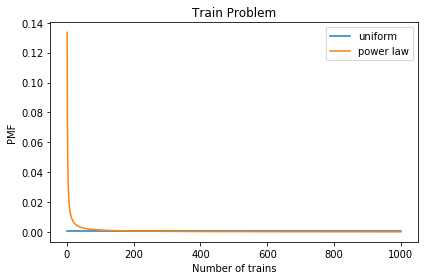

In [37]:
uniform.plot()
power.plot()

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Train Problem')

Now let's see what the posteriors look like after observing one train.

In [38]:
dataset = [60]

update_train(uniform, dataset)
update_train(power, dataset)

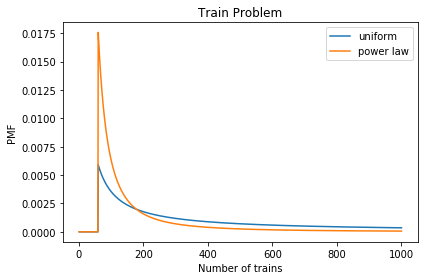

In [39]:
uniform.plot()
power.plot()

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Train Problem')
savefig('fig04-02')

The power law gives less prior probability to high values, which yields lower posterior means, and less sensitivity to the upper bound.

In [40]:
alpha = 1.0
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    ps = hypos**(-alpha)
    power = Pmf(ps, hypos)
    for data in dataset:
        update_train(power, data)
    print(high, power.mean())

500 130.70846986255992
1000 133.2752313750311
2000 133.99746308073125


## Credible intervals

To compute credible intervals, we can use the `credible_interval` method on the posterior.

In [41]:
alpha = 1.0
dataset = [30, 60, 90]

hypos = np.arange(1, 1001)
ps = hypos**(-alpha)
power = Pmf(ps, hypos)
for data in dataset:
    update_train(power, data)

power.credible_interval(0.9)

array([ 91., 242.])

`credible_interval` uses quantile, which we can also use directly.

In [42]:
power.quantile([0.05, 0.95])

array([ 91., 242.])

`quantile` works by making a CDF.

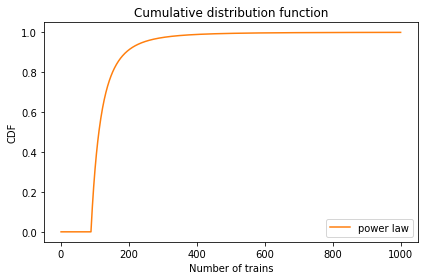

In [45]:
cdf = power.make_cdf()
cdf.plot(color='C1', label='power law')

decorate(xlabel='Number of trains',
         ylabel='CDF',
         title='Cumulative distribution function')
savefig('fig04-03')

The `quantile` function is the inverse of the CDF.

In [46]:
cdf.forward(150)

array(0.7902474)

In [44]:
cdf.inverse([0.05, 0.95])

array([ 91., 242.])

## Exercises

CDF of the Euro problem posterior, and compute a CI

In [61]:
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

In [62]:
likelihood = {
    'H': hypos,
    'T': 1 - hypos
}

def update_euro(pmf, dataset):
    """Updates the Suite with the given number of heads and tails.

    pmf: Pmf representing the prior
    data: tuple of heads and tails
    """
    for data in dataset:
        pmf *= likelihood[data]

    pmf.normalize()

In [64]:
dataset = 'H' * 140 + 'T' * 110
posterior = prior.copy()
update_euro(posterior, dataset)

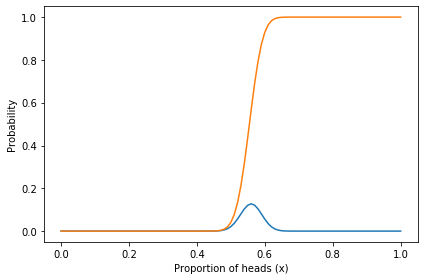

In [70]:
posterior.plot()
posterior.make_cdf().plot()

decorate(xlabel='Proportion of heads (x)',
         ylabel='Probability')

In [66]:
posterior.credible_interval(0.9)

array([0.51, 0.61])

**Exercise:** I often see [rabbits](https://en.wikipedia.org/wiki/Eastern_cottontail) in the garden behind my house, but it's not easy to tell them apart, so I don't really know how many rabbits there are.

Suppose I deploy a motion-sensing [camera trap](https://en.wikipedia.org/wiki/Camera_trap) that takes a picture of the first rabbit it sees each day.  After three days, I compare the pictures and conclude that two of them are the same rabbit and the other is different.

How many rabbits visit my garden?

To answer this question, we have to think about the prior distribution and the likelihood of the data:

* I have sometimes seen four rabbits at the same time, so I know there are at least that many.  I would be surprised if there were more than 10.  So, at least as a starting place, I think a uniform prior from 4 to 10 is reasonable.

* To keep things simple, let's assume that all rabbits who visit my garden are equally likely to be caught by the camera trap in a given day.  Let's also assume it is guaranteed that the camera trap gets a picture every day.

In [47]:
# Solution

hypos = np.arange(4, 11)
prior = Pmf(1, hypos)

,probs
4,1
5,1
6,1
7,1
8,1
9,1
10,1


In [50]:
# Solution

# The probability that the second rabbit is the same as the first is 1/N
# The probability that the third rabbit is different is (N-1)/N

N = hypos
likelihood = (N-1) / N**2

array([0.1875    , 0.16      , 0.13888889, 0.12244898, 0.109375  ,
       0.09876543, 0.09      ])

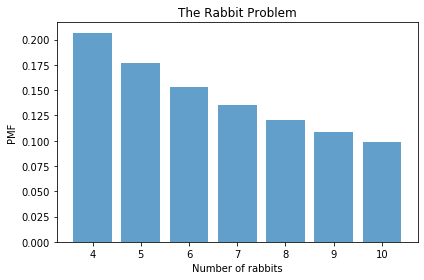

In [54]:
# Solution

posterior = prior * likelihood
posterior.normalize()

posterior.bar(alpha=0.7)
decorate(xlabel='Number of rabbits',
         ylabel='PMF',
         title='The Rabbit Problem')

**Exercise:** Suppose that in the criminal justice system, all prison sentences are either 1, 2, or 3 years, with an equal number of each.  One day, you visit a prison and choose a prisoner at random.  What is the probability that they are serving a 3-year sentence?  What is the average remaining sentence of the prisoners you observe?

In [80]:
# Solution

hypos = np.arange(1, 4)
prior = Pmf(1/3, hypos)
prior

,probs
1,0.333333
2,0.333333
3,0.333333


In [76]:
# Solution

# If you visit a prison at a random point in time,
# the probability of observing any given prisoner
# is proportional to the duration of their sentence.

likelihood = hypos
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
1,0.166667
2,0.333333
3,0.500000


In [78]:
# Solution

# The mean of the posterior is the average sentence.
# We can divide by 2 to get the average remaining sentence.

posterior.mean() / 2

1.1666666666666665

**Exercise:** If I chose a random adult in the U.S., what is the probability that they have a sibling?  To be precise, what is the probability that their mother has had at least one other child.

[This article from the Pew Research Center](https://www.pewsocialtrends.org/2015/05/07/family-size-among-mothers/) provides some relevant data.  From it, I extracted the following distribution of family size for mothers in the U.S. who were 40-44 years old in 2014:

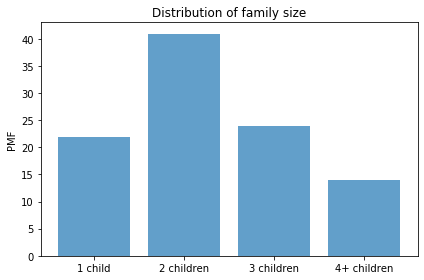

In [92]:
qs = [1, 2, 3, 4]
ps = [22, 41, 24, 14]
prior = Pmf(ps, qs)
prior.bar(alpha=0.7)

plt.xticks(qs, ['1 child', '2 children', '3 children', '4+ children'])
decorate(ylabel='PMF',
         title='Distribution of family size')

For simplicity, let's assume that all families in the 4+ category have exactly 4 children.

In [94]:
# Solution

# When you choose a person a random, you are more likely to get someone
# from a bigger family; in fact, the chance of choosing someone from
# any given family is proportional to the number of children

likelihood = qs
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
1,0.094828
2,0.353448
3,0.310345
4,0.241379


In [95]:
# Solution

# The probability that they have a sibling is the probability
# that they do not come from a family of 1 

1 - posterior[1]

0.9051724137931034

**Exercise:** The [Doomsday argument](https://en.wikipedia.org/wiki/Doomsday_argument) is "a probabilistic argument that claims to predict the number of future members of the human species given an estimate of the total number of humans born so far."

Suppose there are only two kinds of intelligent civilizations that can happen in the universe.  The "short-lived" kind go exinct after only 200 billion individuals are born.  The "long-lived" kind survive until 2,000 billion individuals are born.
And suppose that the two kinds of civilization are equally likely.
Which kind of civilization do you think we live in?  

The Doomsday argument says we can use the total number of humans born so far as data.
According to the [Population Reference Bureau](https://www.prb.org/howmanypeoplehaveeverlivedonearth/), the total number of people who have ever lived is about 108 billion.

Since you were born quite recently, let's assume that you are, in fact, human being number 108 billion.
If $N$ is the total number who will ever live and we consider you to be a randomly-chosen person, it is equally likely that you could have been person 1, or $N$, or any number in between.
So what is the probability that you would be number 108 billion?

Given this data and dubious prior, what is the probability that our civilization will be short-lived?

In [96]:
# Solution

hypos = [200, 2000]
prior = Pmf(1, hypos)

In [97]:
# Solution

likelihood = 1/prior.qs
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
200,0.909091
2000,0.090909


In [98]:
# According to this analysis, the probability is about 91% that our civilization will be short-lived.  
# But this conclusion is based on a dubious prior.

# And with so little data, the posterior depends strongly on the prior.  
# To see that, run this analysis again with a different prior, and see what the results look like.

# What do you think of the Doomsday argument?